In [2]:
!pip install moviepy

  Running setup.py bdist_wheel for moviepy: started
  Running setup.py bdist_wheel for moviepy: finished with status 'done'
  Stored in directory: C:\Users\1\AppData\Local\pip\Cache\wheels\ad\92\4d\a6c6307d4c2219d002646bd4a5987e31fd5697f6ea7778b2c0
Successfully built moviepy


You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [43]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

import keras # broken for keras >= 2.0, use 1.2.2
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape

from utils import load_weights, Box, yolo_net_out_to_car_boxes, draw_box

## construct the tiny-yolo model ##

In [44]:
keras.backend.set_image_dim_ordering('th')

In [45]:
from keras.layers import Activation

In [46]:

model = Sequential()
model.add(Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(64,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(128,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(256,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(512,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(256,1,1 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(512,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(255,1,1 ,border_mode='same'))
model.add(Activation('linear'))


In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_53 (Conv2D)           (None, 16, 448, 448)      448       
_________________________________________________________________
leaky_re_lu_52 (LeakyReLU)   (None, 16, 448, 448)      0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 16, 224, 224)      0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 32, 224, 224)      4640      
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 32, 224, 224)      0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 32, 112, 112)      0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 64, 112, 112)      18496     
__________

## load weight from pretrained weights for yolo ##
The weight file can be downloaded from https://pjreddie.com/darknet/yolo/

In [48]:
load_weights(model,'./yolov3-tiny.weights')

## apply the model to a test image ##

In [49]:
imagePath = './test_images/test1.jpg'
image = plt.imread(imagePath)
image_crop = image[300:650,500:,:]
resized = cv2.resize(image_crop,(448,448))

In [50]:
batch = np.transpose(resized,(2,0,1))
batch = 2*(batch/255.) - 1
batch = np.expand_dims(batch, axis=0)
out = model.predict(batch)

interpolate the vector out from the neural network, generate the boxes

In [51]:
out[0].shape

(255, 7, 7)

In [52]:
boxes = yolo_net_out_to_car_boxes(out[0])

ValueError: cannot reshape array of size 12495 into shape (49,20)

visualize the box on the original image

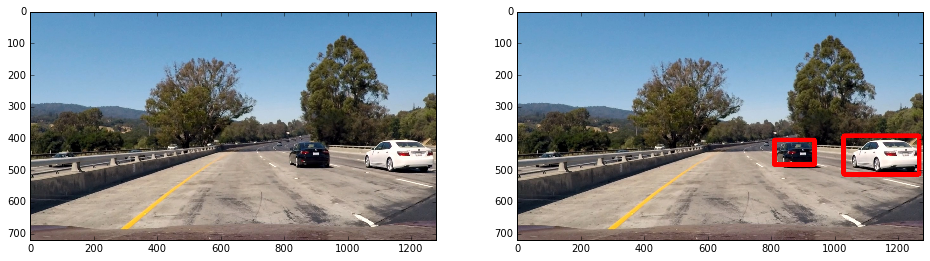

In [9]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
ax1.imshow(image)
ax2.imshow(draw_box(boxes,plt.imread(imagePath),[[500,1280],[300,650]]))

more examples

In [16]:
images = [plt.imread(file) for file in glob.glob('./test_images/*.jpg')]
batch = np.array([np.transpose(cv2.resize(image[300:650,500:,:],(448,448)),(2,0,1)) 
                  for image in images])
batch = 2*(batch/255.) - 1
out = model.predict(batch)
f,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(11,10))
for i,ax in zip(range(len(batch)),[ax1,ax2,ax3,ax4,ax5,ax6]):
    boxes = yolo_net_out_to_car_boxes(out[i], threshold = 0.17)
    ax.imshow(draw_box(boxes,images[i],[[500,1280],[300,650]]))

## apply to video ##

In [6]:
def frame_func(image):
    crop = image[300:650,500:,:]
    resized = cv2.resize(crop,(448,448))
    batch = np.array([resized[:,:,0],resized[:,:,1],resized[:,:,2]])
    batch = 2*(batch/255.) - 1
    batch = np.expand_dims(batch, axis=0)
    out = model.predict(batch)
    boxes = yolo_net_out_to_car_boxes(out[0], threshold = 0.17)
    return draw_box(boxes,image,[[500,1280],[300,650]])

In [7]:
project_video_output = './project_video_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")

In [8]:
lane_clip = clip1.fl_image(frame_func) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|█████████▉| 1260/1261 [01:10<00:00, 17.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

CPU times: user 24.4 s, sys: 3.37 s, total: 27.8 s
Wall time: 1min 11s
